<a href="https://colab.research.google.com/github/subeans/security_project/blob/main/dbscanClustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **이상값 가정 1**
    
    정상값들은 하나 또는 몇 개의 군집에 모여 있고, 이상값은 군집에 속하지 않는다.
    
    데이터에서 군집을 찾아낸 후 제거한 뒤 남아있는 데이터를 이상값으로 처리**.**
    
    DBSCAN ( [wikipedia 설명](https://en.wikipedia.org/wiki/DBSCAN) , [scikit-learn 의 DBSCAN 알고리즘](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html) )ROCK ( [Guha et al., 2000](http://www.facweb.iitkgp.ac.in/~shamik/autumn2012/dwdm/papers/ROCK%20A%20Robust%20Clustering%20Algorithm%20for%20Categorical%20Attributes%20(2000)guha00rock.pdf) )SNN 군집화 ( [ML wiki 설명](http://mlwiki.org/index.php/SNN_Clustering) )
    
- **이상값 가정 2**
    
    **군집의 중심(centroid) 중 가장 가까운 것과의 거리가 짧으면 정상값, 길면 이상값이다.**
    
    **군집화를 하고 데이터가 포함된 군집의 중심과 데이터 개체 사이의 거리를 “이상 score” 로 두고 이용.**
    
    K-means ( [wikipedia 설명](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98) )EM 알고리즘 ( [wikipedia 설명](https://ko.wikipedia.org/wiki/%EA%B8%B0%EB%8C%93%EA%B0%92_%EC%B5%9C%EB%8C%80%ED%99%94_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98) )
    
- **이상값 가정 3**
    
    **정상값은 크거나 조밀한 군집에, 이상값은 작거나 sparse 한 군집에 속한다.**
    
    데이터 개체가 속한 군집의 크기나 밀도가 “이상” 여부를 판단.

## 이상값 가정 1 : DBSCAN 알고리즘 적용
밀도 방식의 클러스터링을 사용하는 DBSCAN(Density-based spatial clustering of applications with noise)

앞에서 설명한 K Means나 Hierarchical 클러스터링의 경우 군집간의 거리를 이용하여 클러스터링을 하는 방법인데, 밀도 기반의 클러스터링은 점이 세밀하게 몰려 있어서 밀도가 높은 부분을 클러스터링 하는 방식이다. 쉽게 설명하면, 어느점을 기준으로 반경 x내에 점이 n개 이상 있으면 하나의 군집으로 인식하는 방식이다.



In [42]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot  as plt
import seaborn as sns


In [2]:
import pandas as pd

In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/security_project/04_hashed.csv")

dataset.columns

Index(['Rdate', 'src_ip', 'dst_ip', 'Proto', 'src_port', 'dst_port', 'Action',
       'src_country', 'dst_country'],
      dtype='object')

In [8]:
def select_unique_Rdate(dataset):
  time_list=[]
  for i in range(len(dataset['Rdate'])):
    time_list.append(dataset.iloc[i]['Rdate'])
  unique_time = set(time_list)
  unique_time = sorted(unique_time)
  print(len(unique_time)) # 24218
  return unique_time 

In [24]:
# feature = dataset[ ['src_ip', 'dst_ip', 'Proto', 'src_port', 'dst_port', 'Action',
#        'src_country', 'dst_country'] ]

feature = dataset[ ['Rdate','src_ip', 'dst_ip', 'src_port', 'dst_port', 'Action']]

In [ ]:
# Rdate의 중복시간제거
unique_time = select_unique_Rdate(feature)

In [26]:
""" 
IPv4 ,각 그룹을 균등화하고 길이가 일치하도록 0 추가 
""" 
def transform_ip(ip): 
  IPV4_GROUP_LENGTH = 3 # IPv4의 각 그룹은 이 길이입니다.
  # IPv4 주소 
  groups = ip.split( "." ) 
  equalize_group_length = "".join( map( lambda group: group.zfill(3), groups )) 
  return equalize_group_length 

"""
Converts the ipAddress column of pandas DataFrame df, to one-hot
Also returns the encoder used
"""
from sklearn.preprocessing import OneHotEncoder

def one_hot_ip(df):
  df['src_ip'] = df.src_ip.apply(lambda ip : transform_ip(ip))
  df['dst_ip'] = df.dst_ip.apply(lambda ip : transform_ip(ip))
  return df

In [27]:
feature_ = one_hot_ip(feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
feature_

,Rdate,src_ip,dst_ip,src_port,dst_port,Action
0,2.021041e+13,154058159102,103177012042,52897,445,2
1,2.021041e+13,154058159020,125066092196,60579,445,2
2,2.021041e+13,154058159164,117121178223,63831,445,2
3,2.021041e+13,154058159165,205034095097,55241,445,2
4,2.021041e+13,154058159102,093056164131,52898,445,2
...,...,...,...,...,...,...
5820305,2.021041e+13,012150252150,102116052100,64259,445,2
5820306,2.021041e+13,012150252150,167212157124,64261,445,2
5820307,2.021041e+13,145217002097,072192214054,25646,23,2
5820308,2.021041e+13,154058159164,185151199060,54633,445,2


In [ ]:
# src_country / dst_country 를 사용하는 경우 
# def labelEncoder(dataset):
#   from sklearn.preprocessing import LabelEncoder
#   job_encode = LabelEncoder()
#   dataset['src_country'] = job_encode.fit_transform(dataset['src_country'])
#   dataset['dst_country'] = job_encode.fit_transform(dataset['dst_country'])
  
#   return dataset

In [ ]:
# feature_ = labelEncoder(feature_)

In [79]:
unique_time[:100]

[20210410000016.64,
 20210410000017.64,
 20210410000018.64,
 20210410000019.64,
 20210410000020.64,
 20210410000021.64,
 20210410000052.64,
 20210410000053.64,
 20210410000124.64,
 20210410000125.64,
 20210410000126.64,
 20210410000127.64,
 20210410000128.64,
 20210410000129.64,
 20210410000130.64,
 20210410000131.64,
 20210410000132.64,
 20210410000202.64,
 20210410000203.64,
 20210410000204.64,
 20210410000205.64,
 20210410000236.64,
 20210410000237.64,
 20210410000238.64,
 20210410000239.64,
 20210410000240.64,
 20210410000310.64,
 20210410000311.64,
 20210410000312.64,
 20210410000342.64,
 20210410000343.64,
 20210410000344.64,
 20210410000345.64,
 20210410000346.64,
 20210410000347.64,
 20210410000348.64,
 20210410000349.64,
 20210410000420.64,
 20210410000421.64,
 20210410000422.64,
 20210410000423.64,
 20210410000424.64,
 20210410000425.64,
 20210410000426.64,
 20210410000427.64,
 20210410000458.64,
 20210410000459.64,
 20210410000500.64,
 20210410000501.64,
 20210410000532.64,


DBSCAN의  매개변수들

- DBSCAN의 주 매개변수
    - **min_samples** : 핵심 포인트를 중심점으로 간주하는 주변 지역의 표본 수
    - **eps** : 핵심 포인트를 중심으로 측정되는 유클리디언 거리값
- **밀집지역(dense region)** : 특성 공간에서 (거리가 가까워서) 데이터가 붐비는 지역
- **핵심 샘플(or 핵심 포인트)** : eps거리 안에 데이터가 지정한 min_samples개수를 만족시키는 밀집지역에 있는 데이터 포인트
- **잡음(noise)** : eps거리 안에 들어오는 포인트 수가 지정한 min_sample보다 적을 경우 어디에도 속하지 않는 잡음으로 레이블됨

DBSCAN 작동 방식 

- **STEP 1** : 특성 공간에서 데이터가 붐비는 밀집지역을 찾고, 그 범위안에서 핵심 샘플이될 포인트를 지정한다.
- **STEP 2** : 어느 데이터 포인트에서 eps거리 안에 데이터가 min_samples개수 만큼 들어 있으면 이 데이터 포인트를 핵심 샘플로 지정한다. 이 경우 해당 데이터 포인트는 새로운 클러스터 레이블로 할당된다. (min_samples개수를 충족시키지 않으면 잡음으로 분류)
- **STEP 3** : 새롭게 할당된 핵심 샘플로 부터 eps거리 안의 포인트가 만약 어떤 클러스터에도 할당되지 않았다면 해당 클러스터 레이블로 할당시킨다. (만약 핵심 샘플이면 그 포인트의 이웃을 차례로 방문)
- **STEP 4** : STEP 1~3을 반복하며 eps거리 안에 더 이상 핵심 샘플이 없을 때까지 자란다.

In [82]:
# #############################################################################
# Compute DBSCAN
def dbscan(feature_):
  from sklearn.preprocessing import StandardScaler
  feature = feature_[ ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'Action']]

  scaler = StandardScaler()

  scaler.fit(feature)
  feature_trans = scaler.transform(feature)
  model = DBSCAN(eps=0.5, min_samples=5)
  predict = pd.DataFrame(model.fit_predict(feature_trans))
  predict.columns = ['predict']
  r = pd.concat([feature,predict],axis=1)
  
  # core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
  # core_samples_mask[model.core_sample_indices_] = True
  labels = model.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print("Dataset Size : ",len(feature))
  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  return r, labels

In [83]:
def pair_plot(r):
  sns.pairplot(r,hue='predict')
  plt.show()


Dataset Size :  27070
Estimated number of clusters: 42
Estimated number of noise points: 289


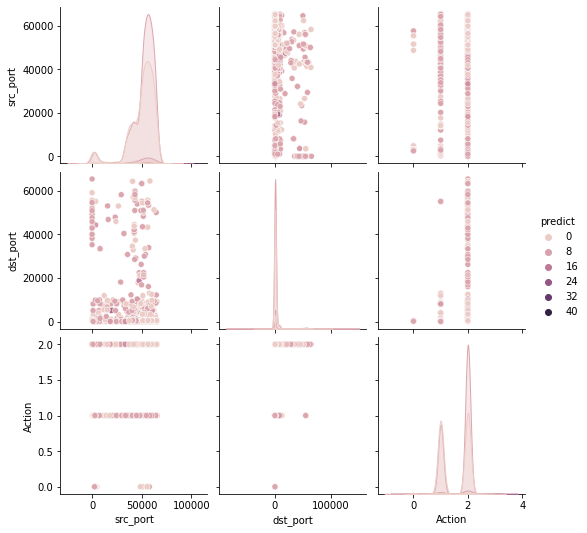

In [78]:
# window size 만큼의의 데이터 추출
window_size = 100
for i in range(len(unique_time)-window_size):
  window_df = pd.DataFrame()
  for j in range(window_size):
    # 특정시간대의 데이터만 추출
    select_time = feature_[feature_['Rdate']==unique_time[i+j]]
    window_df = pd.concat([window_df,select_time])
    
  # 추출된 특정시간대의 데이터만가지고 DBSCAN 진행
  dbscan_result,labels = dbscan(window_df)
  pair_plot(dbscan_result)
  break

In [81]:
dbscan_result[dbscan_result['predict']==-1]

,src_ip,dst_ip,src_port,dst_port,Action,predict
72,154058159102,070079086168,52948.0,445.0,2.0,-1.0
111,018000183206,072192214060,37054.0,443.0,2.0,-1.0
149,154058159165,184096122135,55342.0,445.0,2.0,-1.0
154,154058159102,044206122050,61097.0,445.0,2.0,-1.0
280,012150252150,200222122142,58295.0,445.0,2.0,-1.0
...,...,...,...,...,...,...
26462,154058159020,008062205168,60819.0,445.0,2.0,-1.0
26475,012150252150,103011099157,50164.0,445.0,2.0,-1.0
26521,128200187142,045111016245,37852.0,4332.0,2.0,-1.0
26809,012150252150,130142091251,57577.0,445.0,2.0,-1.0
